# Import/Definitions

In [1]:
%matplotlib inline
import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np


import scintools.ththmod as THTH
from matplotlib.colors import LogNorm
from scipy.optimize import curve_fit, minimize
from scipy.sparse.linalg import eigsh

from scintools.dynspec import BasicDyn, Dynspec

No module named 'skimage'
skimage not found: cannot use biharmonic inpainting


In [2]:
##Curvature evolution with freuquency
def eta_func(f0, A):
    return A / (f0**2)

# Load and Visualize Data

We import the dynamic wavfield <font color='red'>"Sample_Data.npz"</font> and generate a noisy dynamic spectrum by squaring and adding gaussian white noise.

Text(0.5, 1.0, 'Secondary Spectrum')

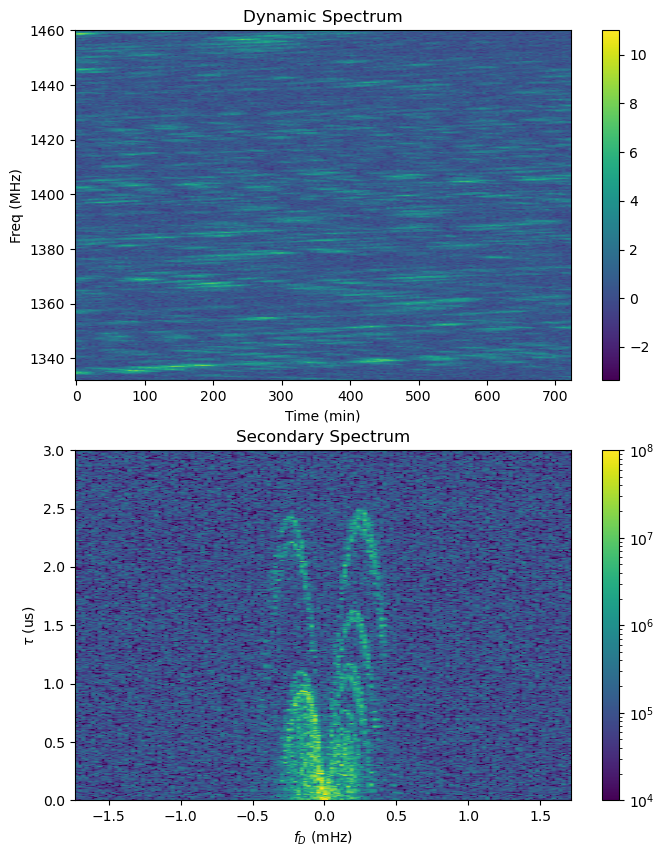

In [3]:
##Load Sample Data
arch = np.load("Sample_Data.npz")
time = arch["t_s"] * u.s
freq = arch["f_MHz"] * u.MHz
##Define Wavefield
espec = arch["Espec"]
##Create noisy dynamic spectrum
dspec = np.abs(espec) ** 2 + np.random.normal(0, 20, espec.shape)
dspec /= dspec.mean()

## Define coordinates for conjugate/secondary spectra
fd = THTH.fft_axis(time, u.mHz)
tau = THTH.fft_axis(freq[:], u.us)

##Sample spectra from portion of data
plt.figure(figsize=(8, 10))
plt.subplot(211)
plt.imshow(
    dspec[:, :],
    origin="lower",
    aspect="auto",
    extent=THTH.ext_find(time.to(u.min), freq[:]),
)
SS = np.fft.fftshift(np.abs(np.fft.fft2(dspec[:, :])) ** 2)
plt.xlabel("Time (min)")
plt.ylabel("Freq (MHz)")
plt.title("Dynamic Spectrum")
plt.colorbar()
plt.subplot(212)
plt.imshow(
    SS,
    norm=LogNorm(vmax=1e8, vmin=1e4),
    origin="lower",
    aspect="auto",
    extent=THTH.ext_find(fd, tau),
)
plt.ylim((0, 3))
plt.colorbar()
plt.xlabel(r"$f_D$ (mHz)")
plt.ylabel(r"$\tau$ (us)")
plt.title("Secondary Spectrum")

In order to get a sense of what a reasonable curvature range would be, we can generate $\theta-\theta$ plots and check for some characteristics of having too high or too low a curvature. Since the model tends to break down when run over large portions of the data, we cut down to a smaller chunk. 

# Examples of $\theta-\theta$ changes from curvature

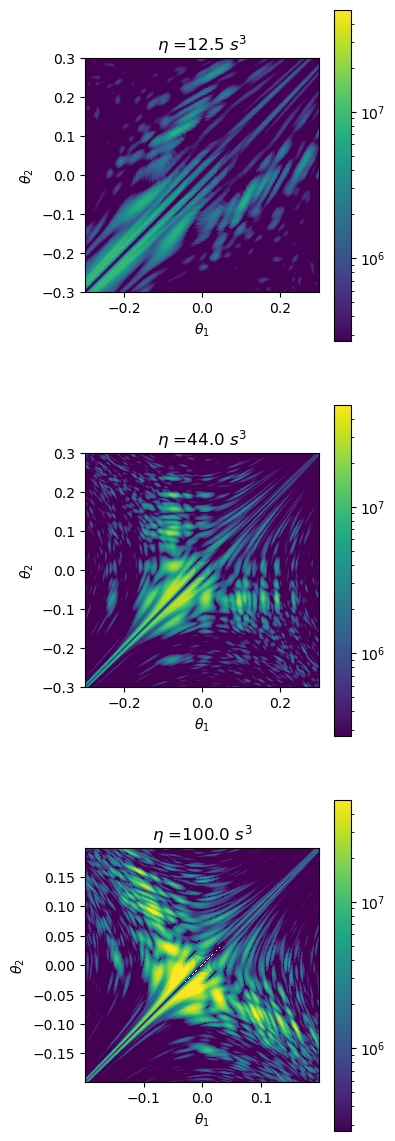

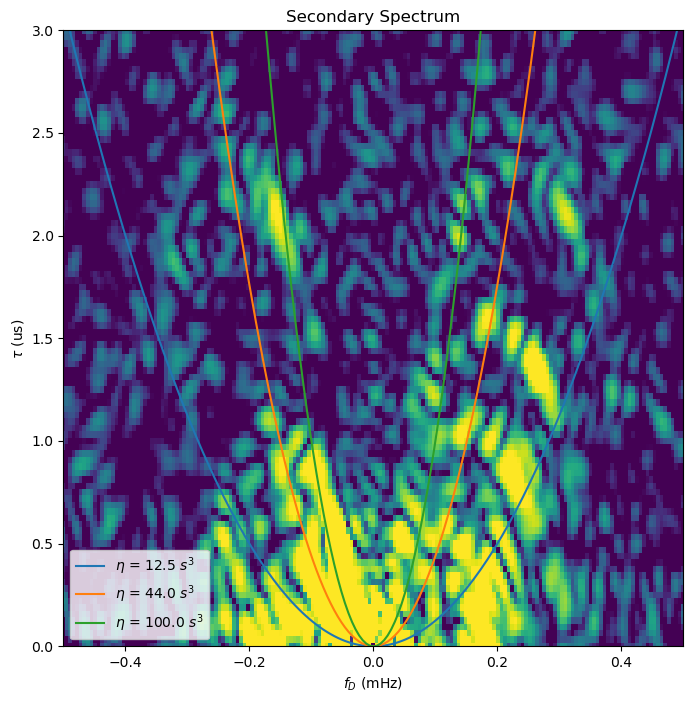

In [4]:
## Choose chunk size
##Frequency width (channels)
cwf = 64
##Time width (integrations)
cwt = dspec.shape[1]

## Choose sample curvatures
etas = np.array([12.5, 44, 100]) * u.us / u.mHz**2

##Sample thth plots for a small portion of data
dspec2 = np.copy(dspec[:cwf, :cwt])
freq2 = freq[:cwf]
time2 = time[:cwt]

##Mean subtraction deals with the problem of the origin being mapped to the who diagonal by setting it to 0
dspec2 -= dspec2.mean()

##Pad before forming secondary spectrum
npad = 3
dspec_pad = np.pad(
    dspec2,
    ((0, npad * dspec2.shape[0]), (0, npad * dspec2.shape[1])),
    mode="constant",
    constant_values=0,
)

##Form CS and SS
CS = np.fft.fftshift(np.fft.fft2(dspec_pad))
SS = np.abs(CS) ** 2

## Define coordinates for conjugate/secondary spectra
fd = THTH.fft_axis(time2, u.mHz, npad)
tau = THTH.fft_axis(freq2, u.us, npad)

plt.figure(figsize=(4, 12))

"""
Define bin edges for thth plot. Should be symmetric about 0 and have an even number of points
ex:edges=np.linspace(-.4,.4,512)*u.mHz
Can also use the automatic edges finding tool (in development) that finds the minimum number of points
to ensure oversampling over a range of fds for a given curvature
"""
edges = THTH.min_edges(0.3 * u.mHz, fd, tau, etas.max(), 1)


## Create thth matrices for example curvatures
thths = list()
for i in range(etas.shape[0]):
    """
    The redmap function returns both the thth matrix and a truncated edges array to ensure the
    matrix never samples points from outside the conjugate spectrum.
    """
    thth_red, edges_red = THTH.thth_redmap(CS, tau, fd, etas[i], edges)
    thths.append((thth_red, edges_red))

## Max and Min values for colorbars
vmax = np.array(
    [np.percentile(np.abs(thths[i][0]) ** 2, 99) for i in range(len(thths))]
).max()
vmin = np.array(
    [np.percentile(np.abs(thths[i][0]) ** 2, 50) for i in range(len(thths))]
).min()

##Create thth plot for each sample curvature
for i in range(etas.shape[0]):
    plt.subplot(3, 1, i + 1)
    plt.imshow(
        np.abs(thths[i][0]) ** 2,
        norm=LogNorm(
            vmin=vmin,
            vmax=vmax,
        ),
        extent=[
            thths[i][1][0].value,
            thths[i][1][-1].value,
            thths[i][1][0].value,
            thths[i][1][-1].value,
        ],
        origin="lower",
    )
    plt.xlabel(r"$\theta_1$")
    plt.ylabel(r"$\theta_2$")
    plt.title(r"$\eta$ =%s $s^3$" % etas[i].to_value(u.s**3))
    plt.colorbar()
plt.tight_layout()

##Show secondary spectrum and sample curvatures
plt.figure(figsize=(8, 8))
plt.imshow(
    SS,
    norm=LogNorm(
        vmax=np.percentile(SS, 99),
        vmin=np.percentile(SS, 50),
    ),
    origin="lower",
    aspect="auto",
    extent=THTH.ext_find(fd, tau),
)
plt.ylim((0, 3))
plt.xlabel(r"$f_D$ (mHz)")
plt.ylabel(r"$\tau$ (us)")
plt.title("Secondary Spectrum")
for i in range(3):
    plt.plot(
        fd, etas[i] * fd**2, label=r"$\eta$ = %s $s^3$" % etas[i].to_value(u.s**3)
    )
plt.xlim((-0.5, 0.5))
plt.legend()

Notice how for low curvatures the $\theta-\theta$ spectrum is skewed along the $\theta_1=\theta_2$ axis, while high curvatures skew along $\theta_1=-\theta_2$

# Running $\theta-\theta$ with scintools

An example of how to do curvature fitting and phase retrieval using $\theta-\theta$ in the dynspec class

## Preparation

In [5]:
## build a BasicDyn object using the arrays imported earlier
bDyne = BasicDyn(
    name='Sample Data',
    header=["Sample Data"],
    times=time.value,
    freqs=freq.value,
    dyn=dspec,
    nsub=time.shape[0],
    nchan=freq.shape[0],
    dt=(time[1] - time[0]).value,
    df=(freq[1] - freq[0]).value,
)

## Convert into a Dynspec object
dyn = Dynspec()
dyn.load_dyn_obj(dyn=bDyne, process=False)

Error: No dynamic spectrum file or object
LOADING DYNSPEC OBJECT Sample Data...
...LOADED in 0.0 seconds

	 OBSERVATION PROPERTIES

filename:			Sample Data
MJD:				None
Centre frequency (MHz):		1396.0
Bandwidth (MHz):		127.9921875
Channel bandwidth (MHz):	0.12511455278581707
Integration time (s):		None
Subintegration time (s):	289.8978362416107


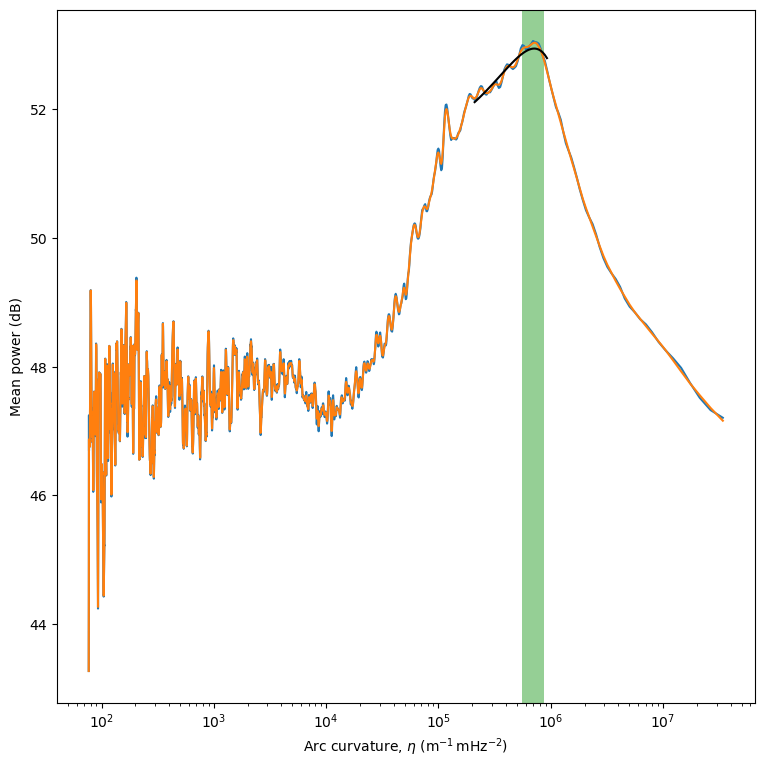


	 THETA-THETA PROPERTIES

Channels per chunk: 1024
Time bins per chunk: 150
Number of fitting chunks: 1x1
Number of mosaic chunks: 1x1
Reference Frequency: 1396.0 MHz
Eta range: 74.25216577415604 s3 to 145.11704751629884 s3 with 68 points
Edges has 14030 point out to 0.2862472577901146 mHz
Fractional fitting width: 0.1
Zero paddings: 3


/Users/danielbaker/miniconda3/envs/pulsar/lib/python3.9/site-packages/scintools-0.2-py3.9.egg/scintools/ththmod.py:1116: UserWarning: edges limit missing units. Assuming mHz.
  warnings.warn(f'{name} missing units. Assuming {desired}.')


In [6]:
dyn.prep_thetatheta(verbose=True,edges_lim=.3)

Edges has too many points in this case. Likely because our chunk size is too high. We reduce the chunk size in frequency, as well as restrict the range of edges to extend just beyond the peak of the most distance arclet we want to model.


	 THETA-THETA PROPERTIES

Channels per chunk: 128
Time bins per chunk: 150
Number of fitting chunks: 8x1
Number of mosaic chunks: 15x1
Reference Frequency: 1396.0 MHz
Eta range: 74.25216577415604 s3 to 145.11704751629884 s3 with 68 points
Edges has 1754 point out to 0.2862472577901146 mHz
Fractional fitting width: 0.1
Zero paddings: 3


/Users/danielbaker/miniconda3/envs/pulsar/lib/python3.9/site-packages/scintools-0.2-py3.9.egg/scintools/ththmod.py:1116: UserWarning: eta_fit missing units. Assuming s3.
  warnings.warn(f'{name} missing units. Assuming {desired}.')
/Users/danielbaker/miniconda3/envs/pulsar/lib/python3.9/site-packages/scintools-0.2-py3.9.egg/scintools/ththmod.py:1116: UserWarning: eta_sig missing units. Assuming s3.
  warnings.warn(f'{name} missing units. Assuming {desired}.')


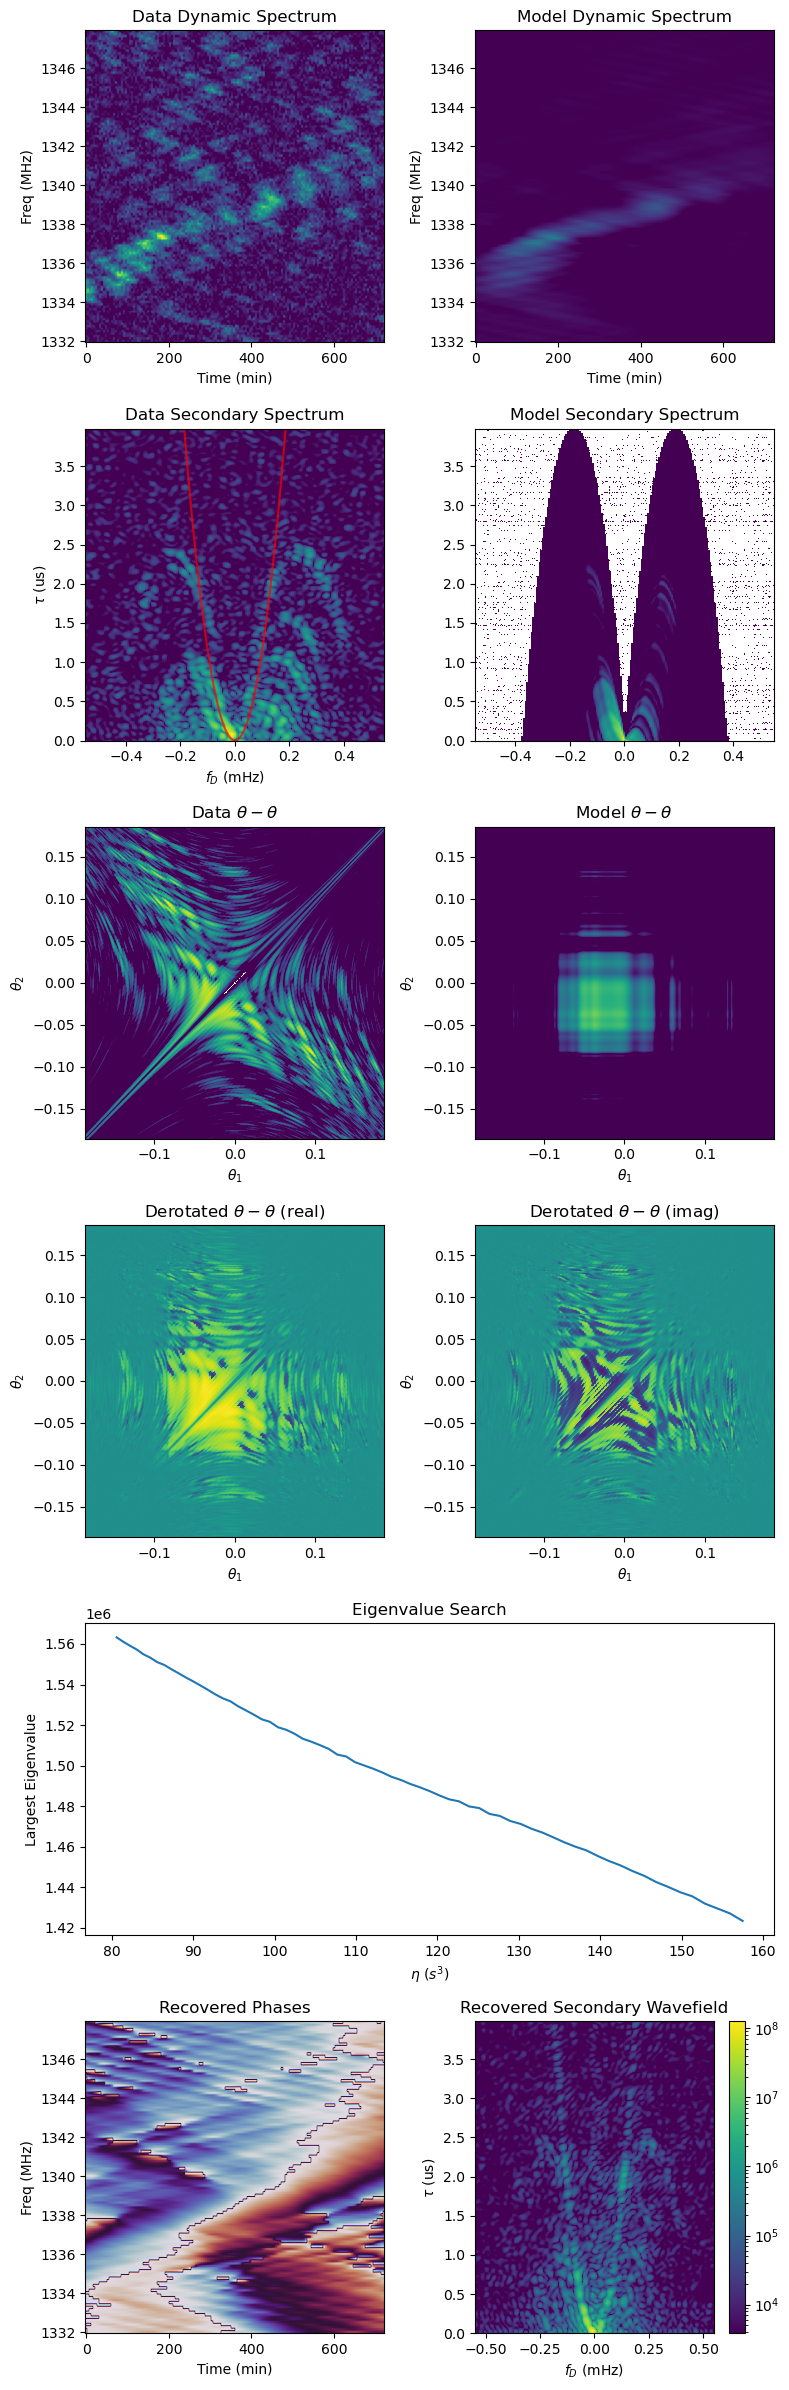

In [7]:
dyn.prep_thetatheta(verbose=True,cwf=128,edges_lim=.3)
dyn.thetatheta_single()

The curvature range looks a bit high so we extend it down a bit


	 THETA-THETA PROPERTIES

Channels per chunk: 128
Time bins per chunk: 150
Number of fitting chunks: 8x1
Number of mosaic chunks: 15x1
Reference Frequency: 1396.0 MHz
Eta range: 30.0 s3 to 145.11704751629884 s3 with 159 points
Edges has 1754 point out to 0.2862472577901146 mHz
Fractional fitting width: 0.1
Zero paddings: 3


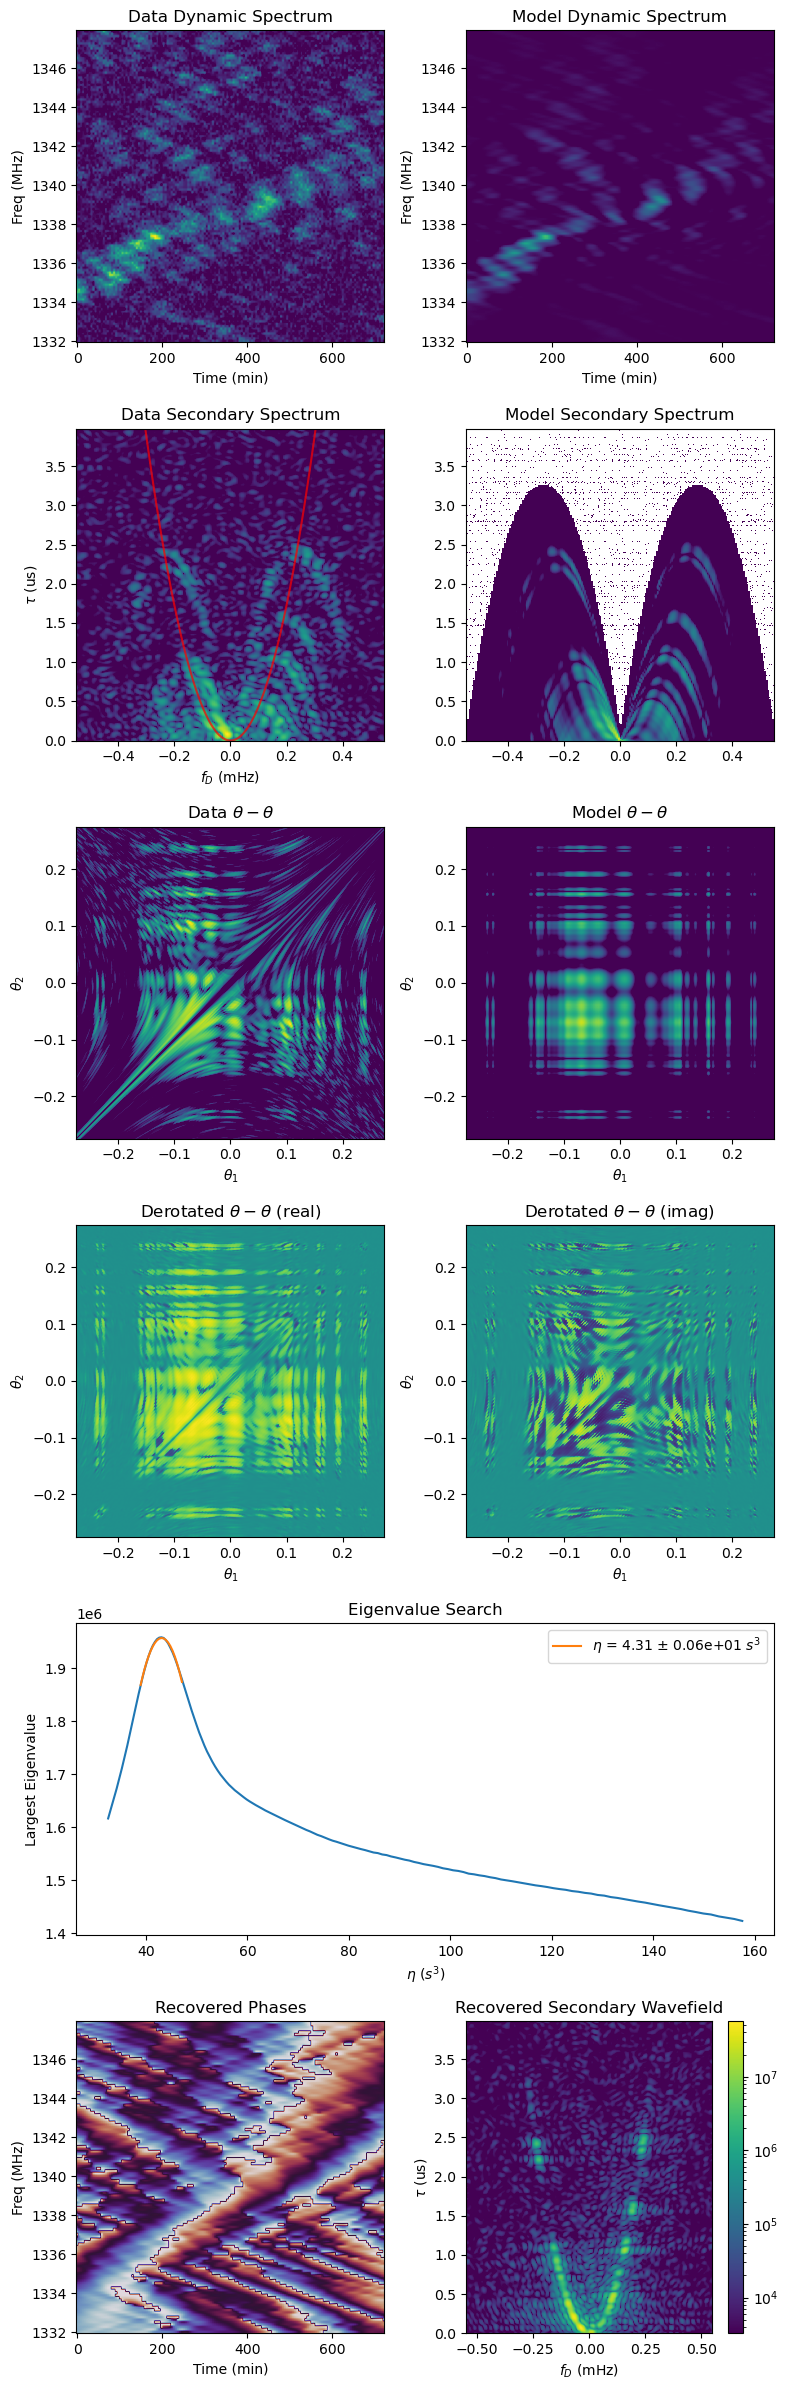

In [8]:
dyn.prep_thetatheta(verbose=True,cwf=128,edges_lim=.3,eta_min=30*u.s**3)
dyn.thetatheta_single()

This looks pretty good. We could try limiting eta_max to make the peak more central (an reduce the number of curvatures to test) or restricting the length in time and frequency


	 THETA-THETA PROPERTIES

Channels per chunk: 64
Time bins per chunk: 150
Number of fitting chunks: 16x1
Number of mosaic chunks: 31x1
Reference Frequency: 1396.0 MHz
Eta range: 30.0 s3 to 50.0 s3 with 52 points
Edges has 302 point out to 0.2862472577901146 mHz
Fractional fitting width: 0.1
Zero paddings: 3


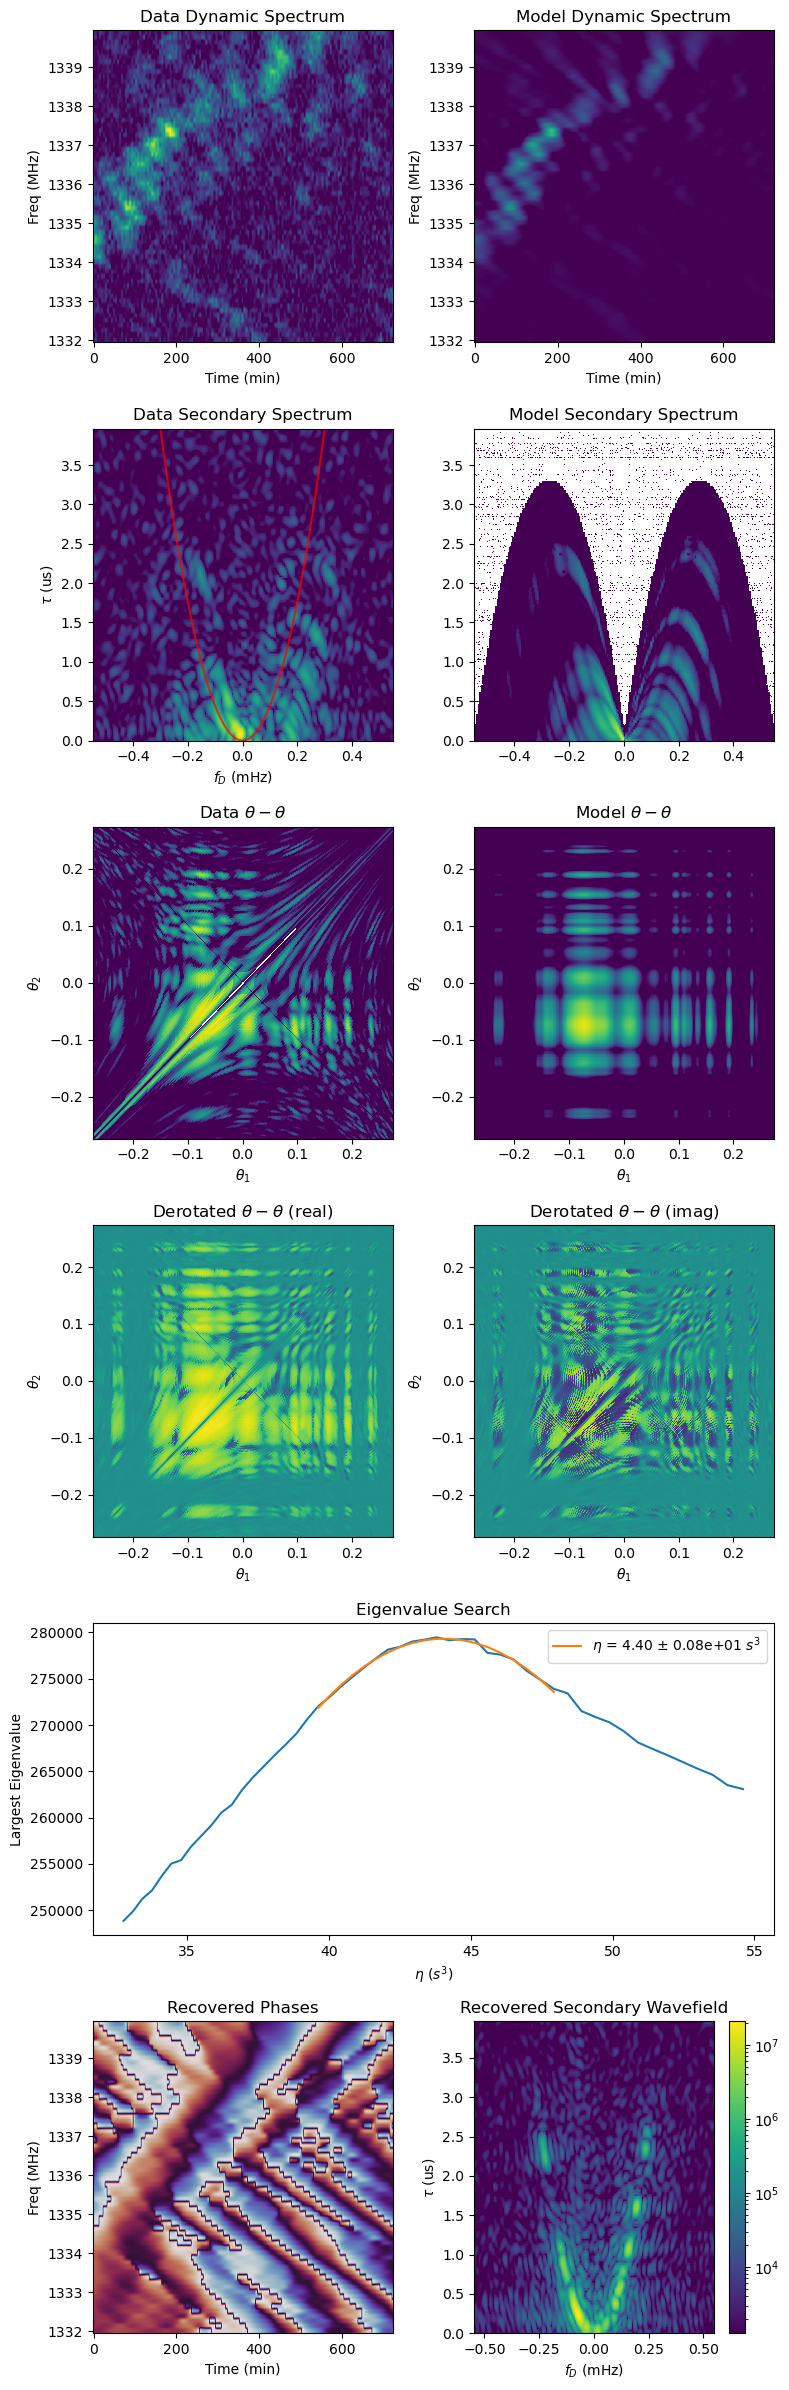

In [9]:
dyn.prep_thetatheta(verbose=True,cwf=64,edges_lim=.3,eta_min=30*u.s**3,eta_max=50*u.s**3)
dyn.thetatheta_single()

## Curvature fitting

Once we've tested our choices for chunk size we can loop over all chunks and fit for the $\frac{1}{f^2}$ dependence

In [ ]:
dyn.fit_thetatheta(verbose=False,plot=True)

### Parallel Calculation

Since fitting each chunk is independant, we can speed things up by using multiprocessing. The example below uses the multiprocessing package, but the MPIPool from mpipool also works.

In [ ]:
from multiprocessing import Pool

In [ ]:
with Pool(4) as pool:
    dyn.fit_thetatheta(verbose=False,plot=True,pool=pool)

In [ ]:
plt.figure()
plt.errorbar(np.ravel(dyn.f0s.value[:,np.newaxis]*np.ones(dyn.eta_evo.shape)),
             np.ravel((dyn.eta_evo-dyn.ththeta*(dyn.fref/dyn.f0s)[:,np.newaxis]**2).value),
             yerr=np.ravel(dyn.eta_evo_err.value),fmt='.')
plt.figure()
plt.hist(np.ravel((dyn.eta_evo-dyn.ththeta*(dyn.fref/dyn.f0s)[:,np.newaxis]**2).value)/np.ravel(dyn.eta_evo_err.value))
h = np.ravel((dyn.eta_evo-dyn.ththeta*(dyn.fref/dyn.f0s)[:,np.newaxis]**2).value)/np.ravel(dyn.eta_evo_err.value)
chi=np.nansum(h**2)/(np.nansum(h)/np.nanmean(h)-1)
chi

## Phase Retrieval

Our phase retrieval approach is to use the best fir curvature above to produce a model wavefield for each chunk that we then stitch together such that the phases in overlapping regions are the same.

In [ ]:
dyn.calc_wavefield()
fd=THTH.fft_axis(dyn.times[:dyn.wavefield.shape[1]]*u.s,u.mHz)
tau=THTH.fft_axis(dyn.freqs[:dyn.wavefield.shape[0]]*u.MHz,u.us)
CWF=np.fft.fftshift(np.fft.fft2(dyn.wavefield))
SWF=np.abs(CWF)**2
plt.figure()
plt.imshow(SWF,origin='lower',aspect='auto',extent=THTH.ext_find(fd,tau),norm=LogNorm(vmin=np.percentile(SWF,75)))
plt.ylim(-1,tau.max().value)
plt.xlabel(r'$f_D~\left(\rm{mHz}\right)$')
plt.ylabel(r'$\tau~\left(\mu\rm{s}\right)$')

We can improve the final wavefield by using two additional pieces of information
1. The amplitude of the wavefield is the squareroot of the dynamic spectrum
2. There are no images with $\tau<0$
   
We can apply these constraints iteratively similar to the Gerchberg–Saxton (GS) algorithm

In [ ]:
dyn.calc_wavefield(gs=True)
fd=THTH.fft_axis(dyn.times[:dyn.wavefield.shape[1]]*u.s,u.mHz)
tau=THTH.fft_axis(dyn.freqs[:dyn.wavefield.shape[0]]*u.MHz,u.us)
CWF=np.fft.fftshift(np.fft.fft2(dyn.wavefield))
SWF=np.abs(CWF)**2
plt.figure()
plt.imshow(SWF,origin='lower',aspect='auto',extent=THTH.ext_find(fd,tau),norm=LogNorm(vmin=np.percentile(SWF,75)))
plt.ylim(-1,tau.max().value)
plt.xlabel(r'$f_D~\left(\rm{mHz}\right)$')
plt.ylabel(r'$\tau~\left(\mu\rm{s}\right)$')

# Detailed Example

If you're interested in a bit more controll or using the reduced chisquared search instead of eigenvalues on each chunk, we present the full versions below

## Chisquared Search

### Single Curvature Measurement

The most important stage of the $\theta-\theta$ process is determining suitable parameters to use in the search.  The most important are

1. cwf : The number of frequency channels to use in each chunk
2. cwt : The number of time bins to use in each chunk
3. edges_max : How far out to search along the main arc (in mHz)
4. nedge : The number of bin edges for the $\theta-\theta$ matrix (Must be even)
5. eta_low : The lower bound of the curvature range to search
6. eta_high : The upper bound of the curvature range to search
7. fw : The fractional width of the region around the minimum of chisq to fit to (sets the length of the orange curve below)

In [ ]:
##Sample Curvature Search and Plots for Small Chunk of Data
##Frequency width (channels)
cwf = 64
##Time width (integrations)
cwt = dspec.shape[1]

##Define range of curvatures to search (find a point clearly above/below the main arc)
eta_low = 0.5 * u.us / (0.04 * u.mHz**2)
eta_high = 4 * u.us / (0.04 * u.mHz**2)

## Detmine size/resolution of theta-theta
edges_max = 0.4 * u.mHz
nedge = 512

## Fitting width
fw = 0.1

##Sample thth plots for a small portion of data
dspec2 = np.copy(dspec[:cwf, :cwt])
freq2 = freq[:cwf]
time2 = time[:cwt]

## Mean subtraction helps thth since the fd=0,tau=0 point is the sum of many pairs of images
mn = dspec2.mean()

##Pad before forming secondary spectrum
npad = 3
dspec_pad = np.pad(
    dspec2 - mn,
    ((0, npad * dspec2.shape[0]), (0, npad * dspec2.shape[1])),
    mode="constant",
    constant_values=0,
)

##Form CS and coordinate arrays
CS = np.fft.fft2(dspec_pad)
CS = np.fft.fftshift(CS)
fd = THTH.fft_axis(time2, u.mHz, npad)
tau = THTH.fft_axis(freq2, u.us, npad)

##Estimate noise in dynamic spectrum
temp = np.fft.fftshift(
    np.abs(np.fft.fft2(dspec) / np.sqrt(dspec.shape[0] * dspec.shape[1])) ** 2
)
N = np.sqrt(temp[: temp.shape[0] // 6, : temp.shape[1] // 6].mean())

##Setup for chisq search
etas = np.linspace(eta_low.value, eta_high.value, 100) * eta_low.unit
chisq = np.zeros(etas.shape[0])

edges = np.linspace(-edges_max, edges_max, nedge)

##Determine chisq for each curvature
mask = np.ones(dspec2.shape, dtype=bool)
for i in range(etas.shape[0]):
    eta = etas[i]
    """
    Fits a model generated by taking the outer product of the dominate eigenvector
    (in theta-theta space) and then mapping back to the dynamic spectrum
    """
    chisq[i] = THTH.chisq_calc(dspec2, CS, tau, fd, eta, edges, mask, N)

##Fit for a parabola around the minimum
e_min = etas[chisq == chisq.min()][0]
etas_fit = etas[np.abs(etas - e_min) < fw * e_min]
chisq_fit = chisq[np.abs(etas - e_min) < fw * e_min]
C = chisq_fit.min()
x0 = etas_fit[chisq_fit == C][0].value
A0 = (chisq_fit[0] - C) / ((etas_fit[0].value - x0) ** 2)
popt, pcov = curve_fit(
    THTH.chi_par, etas_fit.value, chisq_fit, p0=np.array([A0, x0, C])
)
eta_fit = popt[1] * etas.unit
eta_sig = (
    np.sqrt((chisq_fit - THTH.chi_par(etas_fit.value, *popt)).std() / popt[0])
    * etas.unit
)

##Diagnostic plots for fit
THTH.PlotFunc(
    dspec2,
    time2,
    freq2,
    CS,
    fd,
    tau,
    edges,
    eta_fit,
    eta_sig,
    etas,
    chisq,
    etas_fit,
    popt,
    method="chisq",
)

### Full Curvature Analysis

#### Looped Fitting

Using the paramters determined above, we split the dynamic spectrum into as many non-overlapping chunks as we can starting from the earliest time and lowest frequency. If the shape of the dynamic spectrum is not a multiple of the chunk sizes, then he extra data is ignored.

In [ ]:
##Number of frequency chunks across the observation
ncf = dspec.shape[0] // cwf
##Number of time chunks across the observation
nct = dspec.shape[1] // cwt


##Arrays for curvatures in each frequency chunk
f0 = np.zeros((ncf, nct)) * u.MHz
eta_evo = np.zeros((ncf, nct)) * u.us / u.mHz**2
eta_evo_err = np.zeros((ncf, nct)) * u.us / u.mHz**2

##Loop over chunks
for fc in range(ncf):
    for tc in range(nct):
        ##Define dspec and freq array for chunk
        dspec2 = np.copy(dspec[fc * cwf : (fc + 1) * cwf, tc * cwt : (tc + 1) * cwt])
        freq2 = freq[fc * cwf : (fc + 1) * cwf]
        time2 = time[tc * cwt : (tc + 1) * cwt]
        f0[fc, tc] = freq2.mean()

        ##Pad before forming dynamic spectrum
        npad = 3
        dspec_pad = np.pad(
            dspec2,
            ((0, npad * dspec2.shape[0]), (0, npad * dspec2.shape[1])),
            mode="constant",
            constant_values=dspec2.mean(),
        )

        ##Form SS and coordinate arrays
        CS = np.fft.fftshift(np.fft.fft2(dspec_pad))
        fd = THTH.fft_axis(time2, u.mHz, npad)
        tau = THTH.fft_axis(freq2, u.us, npad)

        ##Estimate noise in dynamic spectrum
        temp = np.fft.fftshift(
            np.abs(np.fft.fft2(dspec) / np.sqrt(dspec.shape[0] * dspec.shape[1])) ** 2
        )
        N = np.sqrt(temp[: temp.shape[0] // 6, : temp.shape[1] // 6].mean())

        ##Setup for chisq search
        etas = np.linspace(eta_low.value, eta_high.value, 100) * eta_low.unit
        chisq = np.zeros(etas.shape[0])
        """
        Bin Edges for thth plot
        (should be symmetric about 0 and contain an even number of points)
        The size of thth matrices scales with the square of the number of points in edges
        For this example, fewer points are used in this loop to increase speed.
        """
        edges = np.linspace(-edges_max, edges_max, nedge)
        ##Determine chisq for each curvature
        for i in range(etas.shape[0]):
            eta = etas[i]
            chisq[i] = THTH.chisq_calc(dspec2, CS, tau, fd, eta, edges, mask, N)

        ## Fit for curvature to minimize chisq
        e_min = etas[chisq == chisq.min()][0]
        etas_fit = etas[np.abs(etas - e_min) < fw * e_min]
        chisq_fit = chisq[np.abs(etas - e_min) < fw * e_min]
        C = chisq_fit.min()
        x0 = etas_fit[chisq_fit == C][0].value
        A0 = (chisq_fit[0] - C) / ((etas_fit[0].value - x0) ** 2)
        popt, pcov = curve_fit(
            THTH.chi_par, etas_fit.value, chisq_fit, p0=np.array([A0, x0, C])
        )
        eta_fit = popt[1] * etas.unit
        eta_sig = (
            np.sqrt((chisq_fit - THTH.chi_par(etas_fit.value, *popt)).std() / popt[0])
            * etas.unit
        )

        eta_evo[fc, tc] = eta_fit
        eta_evo_err[fc, tc] = eta_sig

#### Curvature Evolution

We can now fit for the frequency evolution of the curvature ($\eta=\frac{A}{f^2}$)
We try two different approaches here:
1. Solve the linear least squares problem
2. Scale to a reference frequency and take the mean and error on the mean

In [ ]:
fref = 1400 * u.MHz

A = (
    np.sum(eta_evo / (f0 * eta_evo_err) ** 2)
    / np.sum(1 / ((f0**2) * eta_evo_err) ** 2)
).to(u.s**3 * u.MHz**2)
A_err = np.sqrt(1 / np.sum(2 / ((f0**2) * eta_evo_err) ** 2)).to(
    u.s**3 * u.MHz**2
)

etaLS_ref = A / fref**2
errLS_ref = A_err / fref**2

exp_fit = int(("%.0e" % etaLS_ref.value)[2:])
exp_err = int(("%.0e" % errLS_ref.value)[2:])
fmt = "{:.%se}" % (exp_fit - exp_err)
fit_string = fmt.format(etaLS_ref.value)[: 2 + exp_fit - exp_err]
err_string = "0%s" % fmt.format(10 ** (exp_fit) + errLS_ref.value)[1:]

plt.figure()
plt.errorbar(
    np.ravel(f0.value),
    np.ravel(eta_evo.value),
    yerr=np.ravel(eta_evo_err.value),
    fmt=".",
)
plt.plot(
    f0.value,
    eta_func(f0.value, A),
    label=r"$\eta_{%s}$ = %s $\pm$ %s  $s^3$" % (fref.value, fit_string, err_string),
)
plt.title(r"Curvature Evolution")
plt.xlabel("Freq (MHz)")
plt.ylabel(r"$\eta$ ($s^3$)")
plt.legend()

etaM_ref = np.mean(eta_evo * (f0 / fref) ** 2)
errM_ref = np.std(eta_evo * (f0 / fref) ** 2) / np.sqrt(ncf * nct - 1)

exp_fit = int(("%.0e" % etaM_ref.value)[2:])
exp_err = int(("%.0e" % errM_ref.value)[2:])
fmt = "{:.%se}" % (exp_fit - exp_err)
fit_string = fmt.format(etaM_ref.value)[: 2 + exp_fit - exp_err]
err_string = "0%s" % fmt.format(10 ** (exp_fit) + errM_ref.value)[1:]

plt.figure()
plt.hist(np.ravel(eta_evo * (f0 / fref) ** 2).value, bins=10)
# plt.plot(
#     f0.value,
#     eta_func(f0.value, A),
#     label=r"$\eta_{%s}$ = %s $\pm$ %s  $s^3$" % (fref.value, fit_string, err_string),
# )
plt.title(r"Scaled Distribution")
plt.xlabel(r"$\eta_{%s}~\left(\rm{s}^3\right)$" % (fref.value))
plt.ylabel(r"Counts")
plt.axvline(
    etaM_ref.value,
    color="tab:orange",
    label=r"$\eta_{%s}$ = %s $\pm$ %s  $s^3$" % (fref.value, fit_string, err_string),
)
plt.legend()

Both methods are consistant. For now, we use the least squares fit.

### Phase Retrieval

#### Retieve for overlapping chunks

We can now use our measured curvatures to perform phase retrieval on chunks of the data with the diven size. However, since the eigenvalue solution is not unique, we need to calibrate the chunks against each other. In order to do that we take our originial collection of non-overlapping chunks and add in chunks that overlap half way in time and frequency with the chunks arround them.

In [ ]:
##Half widths
hwf = cwf // 2
hwt = cwt // 2

##Number of chunks for the overlapping mosaic
##(each chunk overlaps 50% with adjacent chunks in time and freuency)
ncf = (dspec.shape[0] - hwf) // hwf
nct = (dspec.shape[1] - hwt) // hwt

##Array for storing chunks
chunks = np.zeros((ncf, nct, cwf, cwt), dtype=complex)

for cf in range(ncf):
    for ct in range(nct):
        ##Select Chunk and determine curvature
        dspec2 = np.copy(dspec[cf * hwf : cf * hwf + cwf, ct * hwt : ct * hwt + cwt])
        dspec2 -= dspec2.mean()
        freq2 = freq[cf * hwf : cf * hwf + cwf]
        time2 = time[ct * hwt : ct * hwt + cwt]
        eta = A / (freq2.mean() ** 2)

        ##Pad
        dspec_pad = np.pad(
            dspec2,
            ((0, npad * dspec2.shape[0]), (0, npad * dspec2.shape[1])),
            mode="constant",
            constant_values=dspec2.mean(),
        )

        SS = np.fft.fftshift(np.fft.fft2(dspec_pad))
        fd = THTH.fft_axis(time2, u.mHz, npad)
        tau = THTH.fft_axis(freq2, u.us, npad)

        ##Create and decompose theta-theta
        thth_red, edges_red = THTH.thth_redmap(SS, tau, fd, eta, edges)
        w, V = eigsh(thth_red, 1)
        w = w[0]
        V = V[:, 0]

        ##Construct 1D theta-theta
        thth2_red = thth_red * 0
        thth2_red[thth2_red.shape[0] // 2, :] = np.conjugate(V) * np.sqrt(w)
        ##Map back to time/frequency space
        recov = THTH.rev_map(thth2_red, tau, fd, eta, edges_red, isdspec=False)
        model_E = np.fft.ifft2(np.fft.ifftshift(recov))[
            : dspec2.shape[0], : dspec2.shape[1]
        ]
        model_E *= dspec2.shape[0] * dspec2.shape[1] / 2
        model_E = model_E[: dspec2.shape[0], : dspec2.shape[1]]
        chunks[cf, ct, :, :] = model_E

As a sanity check we compare the model dynamic spetrum for a single chunk to the measured spectrum.

In [ ]:
ds_model = np.abs(chunks[0, 0, :, :]) ** 2
plt.figure()
plt.subplot(211)
plt.imshow(
    ds_model / ds_model.mean(),
    vmax=10,
    origin="lower",
    aspect="auto",
    extent=THTH.ext_find(time[:cwt].to(u.min), freq[:cwf]),
)
plt.xticks([])
plt.ylabel("Freq (MHz)")
plt.title("Single Chunk Model")
plt.subplot(212)
plt.imshow(
    dspec[:cwf, :cwt] / (dspec[:cwf, :cwt].mean()),
    vmax=10,
    origin="lower",
    aspect="auto",
    extent=THTH.ext_find(time[:cwt].to(u.min), freq[:cwf]),
)
plt.xlabel("Time (Min)")
plt.ylabel("Freq (MHz)")
plt.title("Single Chunk Data")
plt.tight_layout()

#### Rotate and combine chunks

In order to build the full model wavefield, we need to determine how to combine our chunks into a single field. We begin by comparing the phases of the overlapping region between two adjacent chunks.

In [ ]:
grid = plt.GridSpec(nrows=3, ncols=10)
plt.figure()
plt.subplot(grid[0, :-1])
plt.imshow(
    np.angle(chunks[0, 0, 32:, :]),
    cmap="twilight",
    origin="lower",
    aspect="auto",
    extent=THTH.ext_find(time[:cwt].to(u.min), freq[cwf // 2 : cwf]),
    interpolation="nearest",
)
plt.xticks([])
plt.ylabel("Freq (MHz)")
plt.title("Phase of top half of chunk 0-0")
plt.subplot(grid[1, :-1])
plt.imshow(
    np.angle(chunks[1, 0, :32, :]),
    cmap="twilight",
    origin="lower",
    aspect="auto",
    extent=THTH.ext_find(time[:cwt].to(u.min), freq[cwf // 2 : cwf]),
    interpolation="nearest",
)
plt.xticks([])
plt.ylabel("Freq (MHz)")
plt.title("Phase of bottom half of chunk 1-0")
plt.subplot(grid[2, :-1])
im = plt.imshow(
    np.angle(chunks[0, 0, 32:, :] * np.conjugate(chunks[1, 0, :32, :])),
    vmin=-np.pi,
    vmax=np.pi,
    cmap="twilight",
    origin="lower",
    aspect="auto",
    extent=THTH.ext_find(time[:cwt].to(u.min), freq[cwf // 2 : cwf]),
    interpolation="nearest",
)
plt.ylabel("Freq (MHz)")
plt.xlabel("Time (Min)")
plt.title("Phase difference")

cax = plt.subplot(grid[:, -1])
plt.colorbar(im, cax, label="Phase")
plt.tight_layout()

Notice how the phase difference is almost constant, but (probably) non-zero. This is due to the random overall phase of the eigenvectors. Each run (even on the same data with the same parameters) will produce difference values of this phase. In order to correct these phases we apply phase rotations to each chunk in order to minimize the imaginary part of $C_iC_j^*$ for the overlapping region of chunks $C_i$ and $C_j$

In [ ]:
phases = THTH.rotInit(chunks)

E_recov = THTH.rotMos(chunks, phases)
E_recov*=np.sqrt(dspec.mean()/np.abs(E_recov**2).mean())

dspec_ext = THTH.ext_find(time.to(u.hour), freq)
plt.figure(figsize=(8, 16))
plt.subplot(222)
plt.imshow(
    np.abs(E_recov) ** 2,
    aspect="auto",
    origin="lower",
    vmin=0,
    vmax=10,
    extent=dspec_ext,
)
plt.xlabel("Time (hrs)")
plt.ylabel("Freq (MHz)")
plt.title("Dynamic Spectrum Model")

plt.subplot(221)
plt.imshow(dspec,
           aspect="auto",
           origin="lower",
           vmin=0,
           vmax=10,
           extent=dspec_ext)
plt.xlabel("Time (hrs)")
plt.ylabel("Freq (MHz)")
plt.title("Dynamic Spectrum")

plt.subplot(224)
plt.imshow(
    np.angle(E_recov),
    cmap="twilight",
    aspect="auto",
    origin="lower",
    extent=dspec_ext
)
plt.xlabel("Time (hrs)")
plt.ylabel("Freq (MHz)")
plt.title("Wave Field Phase Model")
plt.subplot(223)
plt.imshow(
    np.angle(espec),
    cmap="twilight",
    aspect="auto",
    origin="lower",
    extent=dspec_ext
)
plt.xlabel("Time (hrs)")
plt.ylabel("Freq (MHz)")
plt.title("Wave Field Phase")

In [ ]:
plt.figure()
plt.imshow(
    np.angle(espec * np.conjugate(E_recov)),
    cmap="twilight",
    aspect="auto",
    origin="lower",
    extent=dspec_ext,interpolation='nearest'
)
plt.xlabel("Time (hrs)")
plt.ylabel("Freq (MHz)")
plt.title("Phase Difference")
plt.colorbar()
plt.figure(figsize=(8, 8))
plt.subplot(121)
plt.imshow(
    np.angle(E_recov * np.exp(1j * np.angle((espec * np.conjugate(E_recov)).mean()))),
    cmap="twilight",
    aspect="auto",
    origin="lower",
    extent=dspec_ext,interpolation='nearest'
)
plt.xlabel("Time (hrs)")
plt.ylabel("Freq (MHz)")
plt.title("Corrected Phase")
plt.colorbar()
plt.subplot(122)
plt.imshow(
    np.angle(espec), cmap="twilight", aspect="auto", origin="lower", extent=dspec_ext,interpolation='nearest'
)
plt.xlabel("Time (hrs)")
plt.ylabel("Freq (MHz)")
plt.title("Wave Field Phase")
plt.colorbar()

In [ ]:
fd_full = (
    np.fft.fftshift(np.fft.fftfreq(time.shape[0], time[1] - time[0]).to(u.mHz)) * u.mHz
)
tau_full = (
    np.fft.fftshift(np.fft.fftfreq(freq.shape[0], freq[1] - freq[0]).to(u.us)) * u.us
)
SS_ext_full = THTH.ext_find(fd, tau)
temp2 = np.nan_to_num(np.sqrt(dspec)) * np.exp(1j * np.angle(E_recov))

plt.figure(figsize=(8, 8))
plt.subplot(131)
plt.imshow(
    np.abs(np.fft.fftshift(np.fft.fft2(E_recov))) ** 2,
    norm=LogNorm(
        vmax=1e10,
        vmin=1e2,
    ),
    origin="lower",
    aspect="auto",
    extent=SS_ext_full,
)
plt.xlabel(r"$f_D$ (mHz)")
plt.ylabel(r"$\tau$ (us)")
plt.title("Wavefield Model")
plt.xlim((-1, 1))
plt.ylim((-1, 3))
plt.subplot(132)
plt.imshow(
    np.abs(np.fft.fftshift(np.fft.fft2(espec))) ** 2,
    norm=LogNorm(
        vmax=1e10,
        vmin=1e2,
    ),
    origin="lower",
    aspect="auto",
    extent=SS_ext_full,
)
plt.xlabel(r"$f_D$ (mHz)")
plt.ylabel(r"$\tau$ (us)")
plt.title("Wavefield")
plt.xlim((-1, 1))
plt.ylim((-1, 3))

plt.subplot(133)
plt.imshow(
    np.abs(np.fft.fftshift(np.fft.fft2(temp2))) ** 2,
    norm=LogNorm(
        vmax=1e10,
        vmin=1e2,
    ),
    origin="lower",
    aspect="auto",
    extent=SS_ext_full,
)
plt.xlabel(r"$f_D$ (mHz)")
plt.ylabel(r"$\tau$ (us)")
plt.title("Wavefield Model\n(Forced Amplitudes)")
plt.xlim((-1, 1))
plt.ylim((-1, 3))

## Eigenvalue Search (Preferred)

The Eigenvalue Curvature Search is implemented very similarly to the reduced $\chi^2$ fitting above. The main difference is that instead of mapping back to the dynamic spectrum, we look at the largest eigenvalue of the $\theta-\theta$ matrix. This has several advantages: 
* Fewer transformations lead to a faster run time
* No need to worry about resolution in the reversemap (fewer dials)


The only user side change is that the largest eigenvalue at each frequency is given by the function Eval_calc(SS, tau, fd, eta, edges) in the ththmod.py

### Single Chunk

In [ ]:
##Sample Curvature Search and Plots for Small Chunk of Data
##Frequency width (channels)
cwf = 64
##Time width (integrations)
cwt = dspec.shape[1]

##Define range of curvatures to search (find a point clearly above/below the main arc)
eta_low = 0.5 * u.us / (0.04 * u.mHz**2)
eta_high = 4 * u.us / (0.04 * u.mHz**2)

## Detmine size/resolution of theta-theta
edges_max = 0.4 * u.mHz
nedge = 512

## Fitting width
fw = 0.1

##Sample thth plots for a small portion of data
dspec2 = np.copy(dspec[:cwf, :cwt])
freq2 = freq[:cwf]
time2 = time[:cwt]

## Mean subtraction helps thth since the fd=0,tau=0 point is the sum of many pairs of images
mn = dspec2.mean()

##Pad before forming secondary spectrum
npad = 3
dspec_pad = np.pad(
    dspec2-mn,
    ((0, npad * dspec2.shape[0]), (0, npad * dspec2.shape[1])),
    mode="constant",
    constant_values=0,
)

##Form SS and coordinate arrays
CS = np.fft.fftshift(np.fft.fft2(dspec_pad))
fd = THTH.fft_axis(time2, u.mHz, npad)
tau = THTH.fft_axis(freq2, u.us, npad)

##Setup for chisq search
etas = np.linspace(eta_low.value, eta_high.value, 100) * eta_low.unit
eigs = np.zeros(etas.shape[0])
edges = np.linspace(-edges_max, edges_max, nedge)

##Determine chisq for each curvature
for i in range(etas.shape[0]):
    eta = etas[i]
    """
    Instead of doing the inverse mapping, and looking for a minimal chisquare, we look for the largest eigenvalue.
    This line is the only user facing difference between the two methods
    """
    eigs[i] = THTH.Eval_calc(CS, tau, fd, eta, edges)

##Fit for a parabola around the minimum
e_min = etas[eigs == eigs.max()][0]
etas_fit = etas[np.abs(etas - e_min) < fw * e_min]
eigs_fit = eigs[np.abs(etas - e_min) < fw * e_min]
C = eigs_fit.max()
x0 = etas_fit[eigs_fit == C][0].value
A = (eigs_fit[0] - C) / ((etas_fit[0].value - x0) ** 2)
popt, pcov = curve_fit(THTH.chi_par, etas_fit.value, eigs_fit, p0=np.array([A, x0, C]))
eta_fit = popt[1] * etas.unit
eta_sig = (
    np.sqrt(-(eigs_fit - THTH.chi_par(etas_fit.value, *popt)).std() / popt[0])
    * etas.unit
)

THTH.PlotFunc(
    dspec2,
    time2,
    freq2,
    CS,
    fd,
    tau,
    edges,
    eta_fit,
    eta_sig,
    etas,
    eigs,
    etas_fit,
    popt,
)

### Full Curvature Analysis

#### Looped Fitting

In [ ]:
##Number of frequency chunks across the observation
ncf = dspec.shape[0] // cwf
##Number of time chunks across the observation
nct = dspec.shape[1] // cwt


##Arrays for curvatures in each frequency chunk
f0 = np.zeros((ncf, nct)) * u.MHz
eta_evo = np.zeros((ncf, nct)) * u.us / u.mHz**2
eta_evo_err = np.zeros((ncf, nct)) * u.us / u.mHz**2

##Loop over chunks
for fc in range(ncf):
    for tc in range(nct):
        ##Define dspec and freq array for chunk
        dspec2 = np.copy(dspec[fc * cwf : (fc + 1) * cwf, tc * cwt : (tc + 1) * cwt])
        dspec2-=np.nanmean(dspec2)
        freq2 = freq[fc * cwf : (fc + 1) * cwf]
        time2 = time[tc * cwt : (tc + 1) * cwt]
        f0[fc, tc] = freq2.mean()

        ##Pad before forming dynamic spectrum
        npad = 3
        dspec_pad = np.pad(
            dspec2,
            ((0, npad * dspec2.shape[0]), (0, npad * dspec2.shape[1])),
            mode="constant",
            constant_values=0,
        )

        ##Form SS and coordinate arrays
        CS = np.fft.fftshift(np.fft.fft2(dspec_pad))
        fd = THTH.fft_axis(time2, u.mHz, npad)
        tau = THTH.fft_axis(freq2, u.us, npad)

        ##Setup for chisq search
        etas = np.linspace(eta_low.value, eta_high.value, 100) * eta_low.unit
        evals = np.zeros(etas.shape[0])
        edges = np.linspace(-edges_max, edges_max, nedge)
        ##Determine largest eigenvalue for each curvature
        for i in range(etas.shape[0]):
            eta = etas[i]
            evals[i] = THTH.Eval_calc(CS, tau, fd, eta, edges)

        e_min = etas[evals == evals.max()][0]
        etas_fit = etas[np.abs(etas - e_min) < fw * e_min]
        evals_fit = evals[np.abs(etas - e_min) < fw * e_min]
        C = evals_fit.max()
        x0 = etas_fit[evals_fit == C][0].value
        A = (evals_fit[0] - C) / ((etas_fit[0].value - x0) ** 2)
        popt, pcov = curve_fit(
            THTH.chi_par, etas_fit.value, evals_fit, p0=np.array([A, x0, C])
        )
        eta_fit = popt[1] * etas.unit
        eta_sig = (
            np.sqrt(-(evals_fit - THTH.chi_par(etas_fit.value, *popt)).std() / popt[0])
            * etas.unit
        )
    
        eta_evo[fc] = eta_fit
        eta_evo_err[fc] = eta_sig

#### Curvature Evolution

In [ ]:
fref = 1400 * u.MHz

A = (
    np.nansum(eta_evo / (f0 * eta_evo_err) ** 2)
    / np.nansum(1 / ((f0**2) * eta_evo_err) ** 2)
).to(u.s**3 * u.MHz**2)
A_err = np.sqrt(1 / np.nansum(2 / ((f0**2) * eta_evo_err) ** 2)).to(
    u.s**3 * u.MHz**2
)

etaLS_ref = A / fref**2
errLS_ref = A_err / fref**2

exp_fit = int(("%.0e" % etaLS_ref.value)[2:])
exp_err = int(("%.0e" % errLS_ref.value)[2:])
fmt = "{:.%se}" % (exp_fit - exp_err)
fit_string = fmt.format(etaLS_ref.value)[: 2 + exp_fit - exp_err]
err_string = "0%s" % fmt.format(10 ** (exp_fit) + errLS_ref.value)[1:]
if err_string[exp_fit-exp_err+1]=='1':
    exp_err-=1
    fmt = "{:.%se}" % (exp_fit - exp_err)
    fit_string = fmt.format(etaLS_ref.value)[: 2 + exp_fit - exp_err]
    err_string = "0%s" % fmt.format(10 ** (exp_fit) + errLS_ref.value)[1:]

plt.figure()
plt.errorbar(
    np.ravel(f0.value),
    np.ravel(eta_evo.value),
    yerr=np.ravel(eta_evo_err.value),
    fmt=".",
)
plt.plot(
    f0.value,
    eta_func(f0.value, A),
    label=r"$\eta_{%s}$ = %s $\pm$ %s  $s^3$" % (fref.value, fit_string, err_string),
)
plt.title(r"Curvature Evolution")
plt.xlabel("Freq (MHz)")
plt.ylabel(r"$\eta$ ($s^3$)")
plt.legend()

etaM_ref = np.mean(eta_evo * (f0 / fref) ** 2)
errM_ref = np.std(eta_evo * (f0 / fref) ** 2) / np.sqrt(ncf * nct - 1)

exp_fit = int(("%.0e" % etaM_ref.value)[2:])
exp_err = int(("%.0e" % errM_ref.value)[2:])
fmt = "{:.%se}" % (exp_fit - exp_err)
fit_string = fmt.format(etaM_ref.value)[: 2 + exp_fit - exp_err]
err_string = "0%s" % fmt.format(10 ** (exp_fit) + errM_ref.value)[1:]

plt.figure()
plt.hist(np.ravel(eta_evo * (f0 / fref) ** 2).value, bins=10)
# plt.plot(
#     f0.value,
#     eta_func(f0.value, A),
#     label=r"$\eta_{%s}$ = %s $\pm$ %s  $s^3$" % (fref.value, fit_string, err_string),
# )
plt.title(r"Scaled Distribution")
plt.xlabel(r"$\eta_{%s}~\left(\rm{s}^3\right)$" % (fref.value))
plt.ylabel(r"Counts")
plt.axvline(
    etaM_ref.value,
    color="tab:orange",
    label=r"$\eta_{%s}$ = %s $\pm$ %s  $s^3$" % (fref.value, fit_string, err_string),
)
plt.legend()

### Phase Retrieval

#### Retieve for overlapping chunks

In [ ]:
## Chunk Widths in frequency and time:
cwf = 64
cwt = dspec.shape[1]

##Half widths
hwf = cwf // 2
hwt = cwt // 2

##Number of chunks for the overlapping mosaic
##(each chunk overlaps 50% with adjacent chunks in time and freuency)
ncf = (dspec.shape[0] - hwf) // hwf
nct = (dspec.shape[1] - hwt) // hwt

##Array for storing chunks
chunks = np.zeros((ncf, nct, cwf, cwt), dtype=complex)

for cf in range(ncf):
    for ct in range(nct):
        ##Select Chunk and determine curvature
        dspec2 = np.copy(dspec[cf * hwf : cf * hwf + cwf, ct * hwt : ct * hwt + cwt])
        dspec2 -= dspec2.mean()
        freq2 = freq[cf * hwf : cf * hwf + cwf]
        time2 = time[ct * hwt : ct * hwt + cwt]
        eta = A /(freq2.mean()**2)

        ##Pad
        dspec_pad = np.pad(
            dspec2,
            ((0, npad * dspec2.shape[0]), (0, npad * dspec2.shape[1])),
            mode="constant",
            constant_values=dspec2.mean(),
        )

        SS = np.fft.fftshift(np.fft.fft2(dspec_pad))
        fd = THTH.fft_axis(time2, u.mHz, npad)
        tau = THTH.fft_axis(freq2, u.us, npad)

        ##Create and decompose theta-theta
        thth_red, edges_red = THTH.thth_redmap(SS, tau, fd, eta, edges)
        w, V = eigsh(thth_red, 1)
        w = w[0]
        V = V[:, 0]

        ##Construct 1D theta-theta
        thth2_red = thth_red * 0
        thth2_red[thth2_red.shape[0] // 2, :] = np.conjugate(V) * np.sqrt(w)
        ##Map back to time/frequency space
        recov = THTH.rev_map(thth2_red, tau, fd, eta, edges_red, isdspec=False)
        model_E = np.fft.ifft2(np.fft.ifftshift(recov))[
            : dspec2.shape[0], : dspec2.shape[1]
        ]
        model_E *= dspec2.shape[0] * dspec2.shape[1] / 2
        model_E = model_E[: dspec2.shape[0], : dspec2.shape[1]]
        chunks[cf, ct, :, :] = model_E

In [ ]:
ds_model = np.abs(chunks[0, 0, :, :]) ** 2
plt.figure()
plt.subplot(211)
plt.imshow(
    ds_model / ds_model.mean(),
    vmax=10,
    origin="lower",
    aspect="auto",
    extent=THTH.ext_find(time[:cwt].to(u.min), freq[:cwf]),
)
plt.xticks([])
plt.ylabel("Freq (MHz)")
plt.title("Single Chunk Model")
plt.subplot(212)
plt.imshow(
    dspec[:cwf, :cwt] / (dspec[:cwf, :cwt].mean()),
    vmax=10,
    origin="lower",
    aspect="auto",
    extent=THTH.ext_find(time[:cwt].to(u.min), freq[:cwf]),
)
plt.xlabel("Time (Min)")
plt.ylabel("Freq (MHz)")
plt.title("Single Chunk Data")
plt.tight_layout()

#### Rotate and combine chunks

In [ ]:
plt.figure()
plt.subplot(311)
plt.imshow(
    np.angle(chunks[0, 0, 32:, :]),
    cmap="twilight",
    origin="lower",
    aspect="auto",
    extent=THTH.ext_find(time[:cwt].to(u.min), freq[cwf // 2 : cwf]),
)
plt.xticks([])
plt.ylabel("Freq (MHz)")
plt.title("Phase of top half of chunk 0-0")
plt.subplot(312)
plt.imshow(
    np.angle(chunks[1, 0, :32, :]),
    cmap="twilight",
    origin="lower",
    aspect="auto",
    extent=THTH.ext_find(time[:cwt].to(u.min), freq[cwf // 2 : cwf]),
)
plt.xticks([])
plt.ylabel("Freq (MHz)")
plt.title("Phase of bottom half of chunk 1-0")
plt.subplot(313)
plt.imshow(
    np.angle(chunks[0, 0, 32:, :] * np.conjugate(chunks[1, 0, :32, :])),
    vmin=-np.pi,
    vmax=np.pi,
    cmap="twilight",
    origin="lower",
    aspect="auto",
    extent=THTH.ext_find(time[:cwt].to(u.min), freq[cwf // 2 : cwf]),
)
plt.ylabel("Freq (MHz)")
plt.xlabel("Time (Min)")
plt.title("Phase difference")
plt.tight_layout()

In [ ]:
phases = THTH.rotInit(chunks)

E_recov = THTH.rotMos(chunks, phases)
E_recov*=np.sqrt(dspec.mean()/np.abs(E_recov**2).mean())


dspec_ext = THTH.ext_find(time.to(u.hour), freq)
plt.figure(figsize=(8, 16))
plt.subplot(222)
plt.imshow(
    np.abs(E_recov) ** 2,
    aspect="auto",
    origin="lower",
    vmin=0,
    vmax=8,
    extent=dspec_ext,
)
plt.xlabel("Time (hrs)")
plt.ylabel("Freq (MHz)")
plt.title("Dynamic Spectrum Model")
plt.subplot(221)
plt.imshow(dspec, aspect="auto", origin="lower", vmin=0, vmax=8, extent=dspec_ext)
plt.xlabel("Time (hrs)")
plt.ylabel("Freq (MHz)")
plt.title("Dynamic Spectrum")
plt.subplot(224)
plt.imshow(
    np.angle(E_recov), cmap="twilight", aspect="auto", origin="lower", extent=dspec_ext
)
plt.xlabel("Time (hrs)")
plt.ylabel("Freq (MHz)")
plt.title("Wave Field Phase Model")
plt.subplot(223)
plt.imshow(
    np.angle(espec), cmap="twilight", aspect="auto", origin="lower", extent=dspec_ext
)
plt.xlabel("Time (hrs)")
plt.ylabel("Freq (MHz)")
plt.title("Wave Field Phase")

In [ ]:
plt.figure()
plt.imshow(
    np.angle(espec * np.conjugate(E_recov)),
    cmap="twilight",
    aspect="auto",
    origin="lower",
    extent=dspec_ext,
)
plt.xlabel("Time (hrs)")
plt.ylabel("Freq (MHz)")
plt.title("Phase Difference")
plt.colorbar()
plt.figure(figsize=(8, 8))
plt.subplot(121)
plt.imshow(
    np.angle(E_recov * np.exp(1j * np.angle((espec * np.conjugate(E_recov)).mean()))),
    cmap="twilight",
    aspect="auto",
    origin="lower",
    extent=dspec_ext,
)
plt.xlabel("Time (hrs)")
plt.ylabel("Freq (MHz)")
plt.title("Corrected Phase")
plt.colorbar()
plt.subplot(122)
plt.imshow(
    np.angle(espec), cmap="twilight", aspect="auto", origin="lower", extent=dspec_ext
)
plt.xlabel("Time (hrs)")
plt.ylabel("Freq (MHz)")
plt.title("Wave Field Phase")
plt.colorbar()

In [ ]:
fd_full = (
    np.fft.fftshift(np.fft.fftfreq(time.shape[0], time[1] - time[0]).to(u.mHz)) * u.mHz
)
tau_full = (
    np.fft.fftshift(np.fft.fftfreq(freq.shape[0], freq[1] - freq[0]).to(u.us)) * u.us
)
SS_ext_full = THTH.ext_find(fd, tau)
temp2 = np.nan_to_num(np.sqrt(dspec)) * np.exp(1j * np.angle(E_recov))

plt.figure(figsize=(8, 8))
plt.subplot(131)
plt.imshow(
    np.abs(np.fft.fftshift(np.fft.fft2(E_recov))) ** 2,
    norm=LogNorm(
        vmax=1e10,
        vmin=1e2,
    ),
    origin="lower",
    aspect="auto",
    extent=SS_ext_full,
)
plt.xlabel(r"$f_D$ (mHz)")
plt.ylabel(r"$\tau$ (us)")
plt.title("Wavefield Model")
plt.xlim((-1, 1))
plt.ylim((-1, 3))
plt.subplot(132)
plt.imshow(
    np.abs(np.fft.fftshift(np.fft.fft2(espec))) ** 2,
    norm=LogNorm(
        vmax=1e10,
        vmin=1e2,
    ),
    origin="lower",
    aspect="auto",
    extent=SS_ext_full,
)
plt.xlabel(r"$f_D$ (mHz)")
plt.ylabel(r"$\tau$ (us)")
plt.title("Wavefield")
plt.xlim((-1, 1))
plt.ylim((-1, 3))

plt.subplot(133)
plt.imshow(
    np.abs(np.fft.fftshift(np.fft.fft2(temp2))) ** 2,
    norm=LogNorm(
        vmax=1e10,
        vmin=1e2,
    ),
    origin="lower",
    aspect="auto",
    extent=SS_ext_full,
)
plt.xlabel(r"$f_D$ (mHz)")
plt.ylabel(r"$\tau$ (us)")
plt.title("Wavefield Model\n(Forced Amplitudes)")
plt.xlim((-1, 1))
plt.ylim((-1, 3))